# 밀집 신경망(Dense neural network) 학습하기

손으로 쓴 숫자 인식은 분류 문제입니다. 이미지 분류를 위한 가장 간단한 접근 방식인 완전 연결 신경망(Fully-Connected Neural Network; *perceptron*이라고도 부름)부터 시작하겠습니다. `pytorchcv`를 사용하여 이전 단원에서 언급한 모든 데이터를 불러옵니다.

In [1]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

In [10]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

import pytorchcv
pytorchcv.load_mnist()

## Fully-connected dense neural networks

PyTorch의 기본 신경망은 여러 Layer로 구성됩니다. 가장 단순한 네트워크는 선형 Layer라고 하는 하나의 완전 연결층(Fully-Connected-Layer; FCL)만 포함하며, 784개(입력 이미지의 총 픽셀 개수)의 Input과 10개(총 클래스 개수)의 Output이 있습니다.

![A graph showing how an image is broken into layers based on the pixels.](./images/dense-onelayer-network.png)

앞서 언급했듯이 숫자 이미지의 크기는 $1\times28\times28$로, 완전 연결층의 입력 차원이 784이므로 Tensor 모양을 $1\times28\times28$에서 $784$로 변경하려면 **Flatten**이라는 다른 Layer에 입력해야 합니다.


여기서 네트워크의 $n$ 번째 출력이 입력 숫자가 $n$와 같을 확률을 반환하기를 원하지만, 완전 연결층의 출력은 0과 1 사이로 정규화되지 않기 때문에 확률로 생각할 수 없습니다. 따라서 확률로 변환하기 위해 **Softmax**라는 다른 Layer를 적용합니다.

PyTorch에서는 출력 확률의 로그를 계산하는 **LogSoftmax** 함수를 사용하는 것이 더 쉽습니다. 출력 벡터를 실제 확률로 변환하려면 출력값에 **torch.exp**를 적용합니다.

따라서 네트워크의 Architecture는 다음과 같이 표현할 수 있습니다.

![An image showing the architecture of the network broken into a sequence of layers.](./images/onelayer-network-layers.png)

이를 PyTorch에서는 `Sequential` 구문을 사용하여 다음과 같은 방식으로 정의할 수 있습니다.

In [11]:
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax())

## Training the network

이러한 방식으로 정의된 네트워크는 임의의 숫자를 입력으로 사용하고 확률 벡터를 출력으로 생성할 수 있습니다. 데이터셋에서 숫자를 제공하여이 네트워크의 성능을 살펴보겠습니다.

In [12]:
print('Digit to be predicted: ',data_train[0][1])
torch.exp(net(data_train[0][0]))

보시다시피 네트워크는 각 숫자에 대해 유사한 확률을 예측합니다. 이것은 숫자를 인식하는 방법에 대한 훈련을 받지 않았기 때문이며, 훈련하려면 훈련 데이터를 제공해야합니다.

모델을 학습 시키려면 특정 크기(예 : 64)의 데이터 세트 배치(Batch)를 생성해야 하며, PyTorch에는 데이터 배치를 자동으로 생성 할 수있는 **DataLoader**라는 함수가 있습니다.

In [13]:
train_loader = torch.utils.data.DataLoader(data_train,batch_size=64)
test_loader = torch.utils.data.DataLoader(data_test,batch_size=64) # we can use larger batch size for testing

훈련 프로세스 단계는 다음과 같습니다:


1. 입력 데이터(Feature)와 예상 결과(label)로 구성된 입력 데이터 세트에서 미니배치(minibatch)를 가져옵니다.
2. 미니배치에 대한 예측 결과를 계산합니다.
3. 예측 결과와 실제 결과의 차이는 **손실 함수(Loss Function)**를 사용하여 계산됩니다.
4. 모델 가중치(파라미터)와 관련하여 손실 함수의 gradient(기울기)를 계산한 다음 가중치를 조정하여 네트워크 성능을 최적화하는 데 사용합니다. 가중치를 조절하는 양은 **학습률(Learning rate)**이라는 파라미터에 의해 제어되며 최적화 알고리즘의 세부 사항은 **optimizer** 개체에 정의됩니다.
5. 전체 데이터셋이 처리될 때까지 이 단계를 반복합니다. 데이터셋을 통한 하나의 완전한 패스를 **Epoch**라고 합니다.

다음은 훈련을 1 Epoch만큼 수행하는 함수입니다.

In [14]:
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out,labels) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

train_epoch(net,train_loader)

(0.005927660115559896, 0.8927833333333334)

아래 함수는 매우 일반적이므로 다른 예제에서도 사용할 수 있습니다. 이 함수는 아래의 매개 변수를 사용합니다.

* **Neural network**
* **DataLoader** : 학습할 데이터를 정의합니다.
* **Loss Function** : 실제 결과와 네트워크에서 생성된 결과의 차이를 측정하는 함수입니다. 대부분의 분류 작업에서 `NLLLoss`가 사용되어 기본값으로 설정되어 있습니다.
* **Optimizer** : 최적화 알고리즘을 정의한 Optimizer입니다. 가장 전통적인 알고리즘은 확률적 경사 하강법(Stochastic Gradient Descent; SGD)이나, 기본값으로 고급 버전인 Adam을 사용합니다.
* **Learning rate** : 네트워크가 학습하는 속도를 정의합니다. 학습하는 동안 동일한 데이터를 여러 번 표시하고 가중치가 조정될 때마다 표시됩니다. 학습률이 너무 높으면 새 값이 이전 값의 지식을 덮어 씌워 네트워크 성능이 저하되며, 학습률이 너무 낮으면 학습 과정이 매우 느려집니다.

훈련할 때 수행하는 작업은 다음과 같습니다.
* 네트워크를 훈련 모드로 전환합니다.(`net.train ()`)
* 데이터 세트의 모든 배치를 검토하고 각 배치에 대해 다음을 수행합니다.
   - 이 배치에서 네트워크가 만든 예측값을 계산합니다(`out`).
   - 예측값과 실제값의 비유사 정도인 Loss를 계산합니다.
   - 네트워크 가중치를 조정하여 Loss를 최소화합니다(`optimizer.step ()`).
   - 정확하게 예측된 케이스의 수를 계산합니다(**Accuracy**).

이 함수는 데이터 항목 당 평균 Loss와 훈련 Accuracy(올바르게 예측한 사례의 비율)를 계산하고 반환합니다. 훈련 중에 이러한 Loss를 관찰하면 네트워크가 개선 및 데이터가 제대로 학습하고 있는지 확인할 수 있습니다.

평가 데이터셋의 정확도를 제어하는 것도 중요합니다 (**유효성 검사 정확도(Validation Accuracy)** 라고도 함). 매개 변수가 많은 좋은 신경망은 모든 훈련 데이터셋에서 적절한 정확도로 예측할 수 있지만 다른 데이터로 제대로 일반화되지 않을 수 있습니다. 그렇기 때문에 대부분의 경우 데이터의 일부를 따로 설정한 다음, 모델이 데이터에서 얼마나 잘 수행되는지 주기적으로 확인합니다. 다음은 평가 데이터셋에서 네트워크를 평가하는 함수입니다.

In [15]:
def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            out = net(features)
            loss += loss_fn(out,labels) 
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

validate(net,test_loader)

(0.005856306838989258, 0.8936)

훈련 및 검증 정확도를 관찰하는 여러 Epoch 동안 모델을 훈련합니다. 훈련 정확도는 증가하는 반면 유효성 검사 정확도가 감소하는 경우 이를 **과적합(Overfitting)**이라고 부릅니다. 즉, 기존 데이터셋에서는 잘 작동하지만 새 데이터에서는 잘 작동하지 않는 경우를 말합니다.

다음은 훈련과 검증을 모두 수행하는 데 사용할 수 있는 함수입니다. 각 Epoch에 대한 훈련 및 검증 정확도를 출력하고 그래프에 Loss 및 Accuracy를 그리는 데 사용할 수 있는 결과값도 반환합니다.

In [16]:
def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

# Re-initialize the network to start from scratch
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax())

hist = train(net,train_loader,test_loader,epochs=5)

Epoch  0, Train acc=0.893, Val acc=0.893, Train loss=0.006, Val loss=0.006
Epoch  1, Train acc=0.910, Val acc=0.899, Train loss=0.005, Val loss=0.006
Epoch  2, Train acc=0.913, Val acc=0.899, Train loss=0.005, Val loss=0.006
Epoch  3, Train acc=0.915, Val acc=0.897, Train loss=0.005, Val loss=0.006
Epoch  4, Train acc=0.916, Val acc=0.896, Train loss=0.005, Val loss=0.006


이 함수는 각 Epoch의 훈련 및 검증 데이터에 대한 정확성과 함께 메시지를 기록하며, 이를 Dictonary 형태로 반환합니다. 이를 **History**라고 부르며, 이를 시각화하여 모델 학습을 더 잘 이해할 수 있습니다.

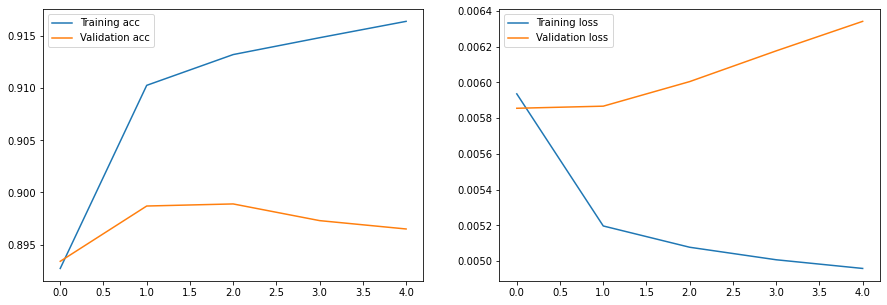

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()

왼쪽의 그래프는 'Training Accuracy'가 증가하는 것을 보여주는 반면(훈련 데이터를 더 잘 분류하기위한 네트워크 학습에 해당함) 'Validation Accuracy'가 떨어지기 시작합니다. 오른쪽의 그래프는 'Training Loss'와 'Validation Loss'를 보여주며, 'Training Loss'가 점차 감소(성능이 우수함을 의미)하고 'Validation Loss'가 점차 증가(성능이 나빠짐을 의미)하는 것을 볼 수 있습니다. 이 그래프는 모델이 **과적합** 상태임을 나타냅니다.

## Visualizing network weights

이제 신경망의 가중치를 시각화하고 어떻게 생겼는지 살펴보겠습니다. 네트워크가 하나의 Layer보다 더 복잡한 경우 이와 같은 결과를 시각화하기가 어려울 수 있습니다. 그러나 이번 예제(숫자 분류)의 경우 초기 이미지에 가중치 행렬을 곱하여 추가된 논리로 네트워크 가중치를 시각화할 수 있습니다.

크기가 784x10 인`weight_tensor`를 만들어 보겠습니다. 이 텐서는 `net.parameters ()` 메소드를 호출하여 얻을 수 있습니다. 예제에서 숫자가 0인지 아닌지 확인하려면 입력 숫자에 `weight_tensor [0]`을 곱하고 결과를 softmax normalization을 통해 전달하여 결과를 얻게 되며, 가중치 Tensor 요소가 분류하는 숫자의 평균 모양과 다소 유사한 것을 확인할 수 있습니다.

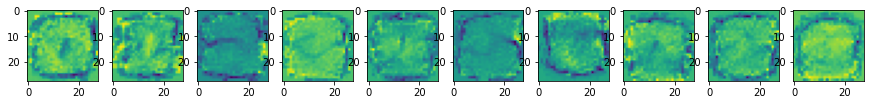

In [18]:
weight_tensor = next(net.parameters())
fig,ax = plt.subplots(1,10,figsize=(15,4))
for i,x in enumerate(weight_tensor):
    ax[i].imshow(x.view(28,28).detach())

## Takeaway 

PyTorch에서 신경망 훈련은 훈련 루프로 프로그래밍할 수 있습니다. 복잡한 프로세스처럼 보일 수 있지만 실제로는 한 번만 작성하면 나중에 변경하지 않고 이 훈련 코드를 다시 사용할 수 있습니다.

이미 Single-Layer Dense 신경망이 상대적으로 우수한 성능을 보여주지만 정확도를 91% 이상으로 높이고 싶습니다! 다음 단원에서는 Multi-Level Perceptrons를 사용해 보겠습니다.